In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd, gluon, optimizer
from mxnet.image import color_normalize
mx.random.seed(1)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
mx.__version__

'1.1.0'

## Set the context

In [3]:
ctx = mx.gpu()

## Load our data

In [4]:
#Binary Classifier
num_outputs = 1
batch_size = 64

train_data = mx.io.ImageRecordIter(path_imgrec='lego_train.rec',
                                   min_img_size=512,
                                   data_shape=(3, 512, 512),
                                   rand_crop=False,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   rand_mirror=True)

test_data = mx.io.ImageRecordIter(path_imgrec='lego_val.rec',
                                 min_img_size=512,
                                 data_shape=(3, 512, 512),
                                 batch_size=batch_size)

train_data.reset()
test_data.reset()


(64, 3, 512, 512)


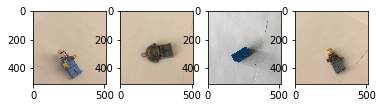

In [5]:
batch = train_data.next()
data = batch.data[0]
print(data.shape)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))

## Define a convolutional neural network

Again, a few lines here is all we need in order to change the model. Let's add a couple of convolutional layers using gluon.nn.



In [6]:
num_fc = 1024
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))            
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

## Parameter Initialization

In [7]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

## Loss Function

In [8]:
sigmoid_binary_cross_entropy = gluon.loss.SigmoidBinaryCrossEntropyLoss()
softmax_loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer

In [1]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.001})

NameError: name 'gluon' is not defined

## Accuracy Evaluation

In [10]:
metric = mx.metric.create(['rmse'])

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        metric.update(label, outputs)
    out = metric.get()
    metric.reset()
    return out


## Training Loop

In [ ]:
epochs = 1
smoothing_constant = .01
moving_loss = 0

train_data.reset()

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(nd.array(batch.data[0]), ctx_list=[ctx])
        label = gluon.utils.split_and_load(nd.array(batch.label[0]), ctx_list=[ctx])
        
        with autograd.record():
            for x, y in zip(data, label):
                output = net(x)
                loss = sigmoid_binary_cross_entropy(output, y)
        loss.backward()
        trainer.step(64)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
        
    test_accuracy = evaluate(net, test_data, [ctx])
    train_accuracy = evaluate(net, train_data, [ctx])
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

## Time to Test!

In [15]:
from skimage import data, io, filters, transform

minifigure = io.imread("/tmp/minifigure.jpg")
minifigure = transform.resize(minifigure, (512, 512))

brick = io.imread("/tmp/brick.jpg")
brick = transform.resize(brick, (512, 512))

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


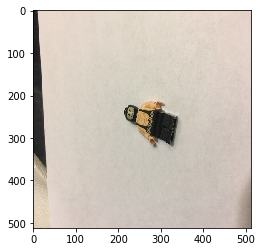

In [16]:
plt.imshow(minifigure)

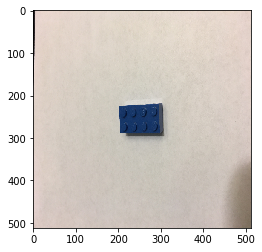

In [17]:
plt.imshow(brick)

In [18]:
minifigure = np.array(minifigure)
minifigure = minifigure.reshape((1, 3, 512, 512))

In [19]:
print(minifigure.shape)

with mx.Context(ctx):
    output = net(nd.array(minifigure))
    
print(output)

(1, 3, 512, 512)

[[ 0.05397465]]
<NDArray 1x1 @gpu(0)>


In [20]:
brick = np.array(brick)
brick = brick.reshape((1, 3, 512, 512))

with mx.Context(ctx):
    print(net(nd.array(brick)))


[[ 0.05397465]]
<NDArray 1x1 @gpu(0)>
